In [10]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_UCR_UEA_dataset

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, precision_recall_fscore_support 

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train, y_train = load_UCR_UEA_dataset(name="EthanolConcentration",
                                        split='train', 
                                        return_type='numpy3D',
                                        extract_path="./data")
X_test, y_test = load_UCR_UEA_dataset(name="EthanolConcentration",
                                      split='test', 
                                      return_type='numpy3D',
                                      extract_path='./data')

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(261, 3, 1751) (261,)
(263, 3, 1751) (263,)


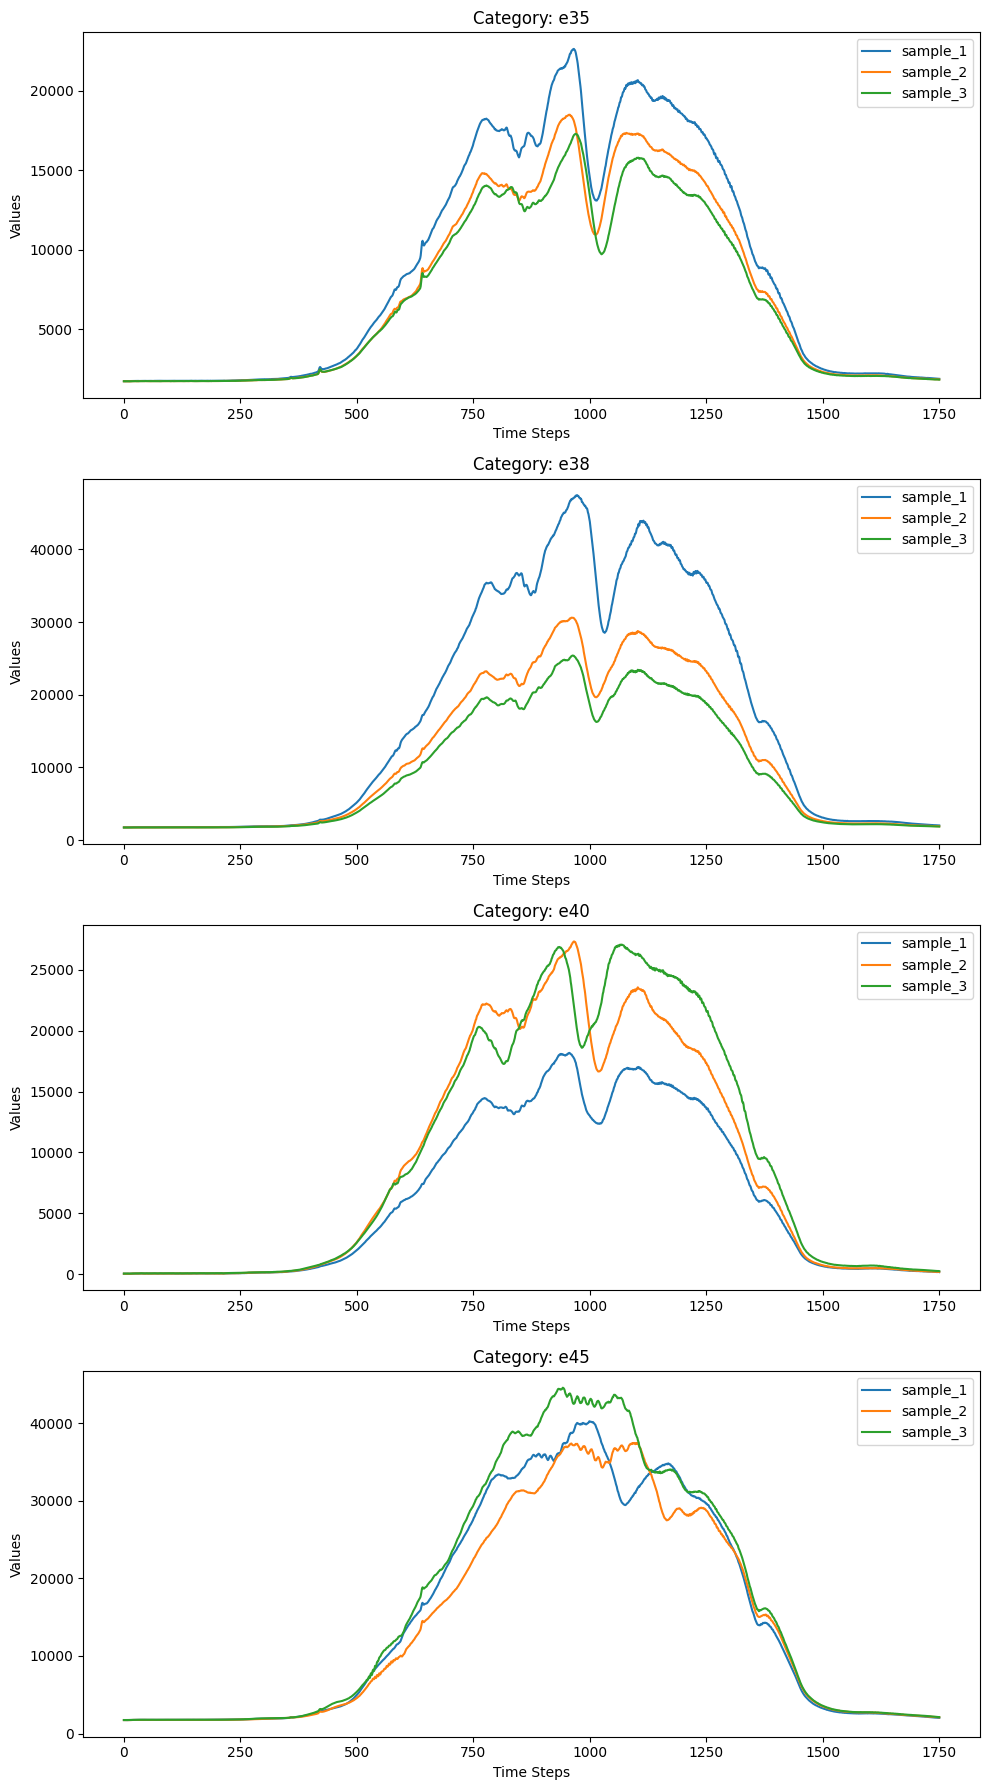

In [6]:
unique_values, indices = np.unique(y_train, return_index=True)
features = ["sample_1", "sample_2", "sample_3"]

selected_series = X_train[indices]

fig, axes = plt.subplots(4, 1, figsize=(10, 18))

for i in range(len(indices)):  
    for j in range(selected_series.shape[1]):
        axes[i].plot(selected_series[i, j], label=features[j])

    axes[i].set_title(f"Category: {unique_values[i]}")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Values")
    axes[i].legend()

plt.tight_layout()
plt.show()

## Baseline

In [12]:
from sktime.classification.dummy import DummyClassifier

start = time.time()

clf = DummyClassifier(strategy='stratified', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end = time.time()

baseline_p, baseline_r, baseline_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
baseline_time = end-start
print(baseline_time)

0.07500100135803223


## Distance-based: KNN

In [13]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()

params = {
    "n_neighbors": [1,5],
    "distance": ['euclidean', 'dtw']
}

start = time.time()

tuned_clf = GridSearchCV(
    knn, 
    params, 
    cv=KFold(n_splits=10)
)
tuned_clf.fit(X_train, y_train)
y_pred = tuned_clf.predict(X_test)

end = time.time()

knn_p, knn_r, knn_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)

knn_time = end-start
print(knn_time)

3730.1084043979645


## Dictionary-based: MUSE

In [14]:
from sktime.classification.dictionary_based import MUSE

start = time.time()

muse = MUSE(n_jobs=-1, random_state=42)
muse.fit(X_train, y_train)
y_pred = muse.predict(X_test)

end = time.time()

muse_p, muse_r, muse_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
muse_time = end-start
print(muse_time)

135.14232683181763


## Ensemble: Bagging

In [17]:
from sktime.classification.ensemble import BaggingClassifier
from sktime.classification.dictionary_based import WEASEL
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)

start = time.time()

base_clf = WEASEL(alphabet_size=3,support_probabilities=True, random_state=42)
clf = BaggingClassifier(base_clf, n_estimators=3, n_features=1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = encoder.inverse_transform(y_pred)

end = time.time()

bagging_p, bagging_r, bagging_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
bagging_time = end-start
print(bagging_time)

124.12475180625916


## Feature-based: Summary classifier

In [18]:
from sktime.classification.feature_based import SummaryClassifier
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

knn_clf = KNeighborsClassifier(n_neighbors=1)
clf = SummaryClassifier(
    summary_functions=("mean", "min", "max", "median", "sum", "skew", "kurt", "var", "std", "mad", "sem", "nunique", "count"),
    estimator=knn_clf,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end = time.time()

summary_p, summary_r, summary_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
summary_time = end-start
print(summary_time)

10.364614725112915


## Interval-based: DrCIF

In [19]:
from sktime.classification.interval_based import DrCIF

drcif = DrCIF(
    n_estimators=5,
    n_intervals=2,        
    att_subsample_size=8,
    min_interval=3,
    max_interval=None, 
    base_estimator="CIT",
    n_jobs=-1,
    random_state=42
)

params = {
    "n_estimators": [1, 2, 3, 4, 5]
}

start = time.time()

tuned_drcif = GridSearchCV(
    drcif,
    params,
    cv=KFold(n_splits=10)
)

tuned_drcif.fit(X_train, y_train)
y_pred = tuned_drcif.predict(X_test)

end = time.time()

drcif_p, drcif_r, drcif_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
drcif_time = end-start
print(drcif_time)

159.3206753730774


## Kernel-based: Rocket

In [20]:
from sktime.classification.kernel_based import RocketClassifier

start = time.time()

clf = RocketClassifier(
    num_kernels=1000,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end = time.time()

rocket_p, rocket_r, rocket_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
rocket_time = end-start
print(rocket_time)

41.94583559036255


## Shapelet classifier

In [21]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

start = time.time()

clf = ShapeletTransformClassifier(
    n_shapelet_samples=50,
    max_shapelets=50,
    time_limit_in_minutes=5,
    contract_max_n_shapelet_samples=50,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end = time.time()

shapelet_p, shapelet_r, shapelet_f1, _ = precision_recall_fscore_support(
    y_test, 
    y_pred,
    average="weighted"
)
shapelet_time = end-start
print(shapelet_time)

329.3000364303589


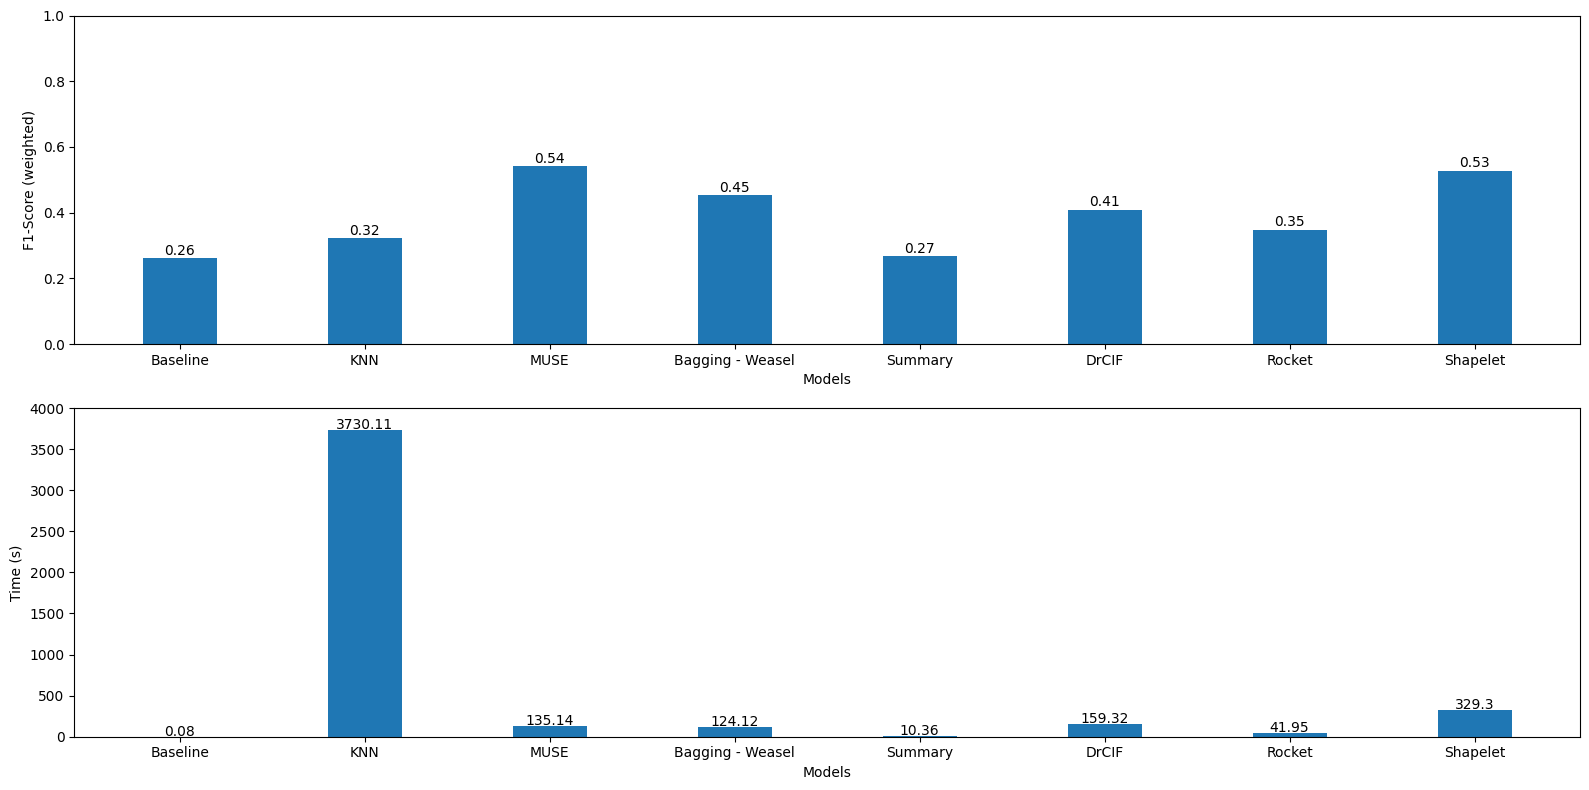

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,8))

x = ["Baseline", "KNN", "MUSE", "Bagging - Weasel", "Summary", "DrCIF", "Rocket", "Shapelet"]
y1 = [baseline_f1, knn_f1, muse_f1, bagging_f1, summary_f1, drcif_f1, rocket_f1, shapelet_f1]
y2 = [baseline_time, knn_time, muse_time, bagging_time, summary_time, drcif_time, rocket_time, shapelet_time]

ax1.bar(x, y1, width=0.4)
ax1.set_xlabel('Models')
ax1.set_ylabel('F1-Score (weighted)')
ax1.set_ylim(0, 1)

for i, v in enumerate(y1):
    ax1.text(x=i, y=v+0.01, s=str(round(v, 2)), ha='center')

ax2.bar(x, y2, width=0.4)
ax2.set_xlabel('Models')
ax2.set_ylabel('Time (s)')
ax2.set_ylim(0, 4000)

for i, v in enumerate(y2):
    ax2.text(x=i, y=v+10, s=str(round(v, 2)), ha='center')

plt.tight_layout()